In [1]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

# Network model

In [2]:
from functions_library import *

# Gurobi Optimization
Implementation of the LP, which Arash proposed on 6. June 2022

In [3]:
opt_mod = gb.Model(name="linear programm")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-02


## Setup Network Parameters

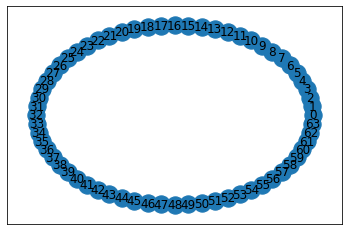

In [4]:
k = 6
G = init_ring(2**k)
D = init_uniformDemand_matrix(G)
#D[0][15] = 1
#adjM = np.full((2**k,2**k),0)
#A = nx.adjacency_matrix(G)

## Setting variables

In [5]:
n = len(G.nodes)

nodesPairList = gb.tuplelist(complete_node_pair_list(G))
allShortestPath = nx.shortest_path(G)

e = opt_mod.addMVar((len(G.nodes), len(G.nodes)), name="e", vtype="B")
dist = opt_mod.addMVar((len(G.nodes), len(G.nodes)), name="dist", vtype="I", lb=0, ub=GRB.INFINITY)
x = opt_mod.addMVar((len(G.nodes), len(G.nodes),len(G.nodes), len(G.nodes)), name="x", vtype="B")
opt_mod.update() 

## Adding constraints

In [ ]:
# Adjacency Matrix (e) Constraints
maxNumberE = math.log(2**k,2) + 2
opt_mod.addConstrs((e[i,(i+1) % len(G.nodes)] == 1 for i in G.nodes), name="c-ring")
opt_mod.addConstrs((e[i,i] == 0 for i in G.nodes), name="c-noSelfEdge")
opt_mod.addConstrs((e[i,:].sum() <= maxNumberE for i in G.nodes), name="c-logE")
opt_mod.addConstrs((e[i,j] == e[j,i] for i in G.nodes for j in G.nodes), name="c-undirected")
        
    
# Distance Matrix (dist) Constraints. dist[i][j]:= SP-length between i and j
opt_mod.addConstrs((x[i,j,:,:].sum()/2==dist[i,j] for i in G.nodes for j in G.nodes), name="c-subpath0")
opt_mod.addConstrs((dist[i,j] <= dist[i,u] + dist[u,j] for i in G.nodes for j in G.nodes for u in G.nodes),
                  name="c-dist2")




# Ensuring that x shows a correct path
opt_mod.addConstrs((x[i,j,i,i] == 0 for i in G.nodes for j in G.nodes), name="c-noSelfE")
opt_mod.addConstrs((x[i,j,i,:].sum() == 1 for i in G.nodes for j in G.nodes), name="c-flowStart")
opt_mod.addConstrs((x[i,j,u,v] <= e[u,v] for i in G.nodes for j in G.nodes for u in G.nodes for v in G.nodes),
                  name="flow0")
for i in G.nodes:
    for j in G.nodes:
        if i != j:
            opt_mod.addConstr(x[i,j,i,:].sum() == 1, name="c-flowStart")
            opt_mod.addConstr(x[i,j,:,j].sum() == 1, name="c-flowEnd")
            for v in G.nodes:
                if v != j:
                    opt_mod.addConstr((x[i,j,:,v].sum() - x[i,j,v,:].sum()) == 0, name="blue0")

## Objective

In [ ]:
#print(len(x[0,1,x,y]))
nodesPairListNoDuplication = complete_node_pair_list_noDuplication(G)
opt_mod.setObjective(sum([dist[i,j]*D[i][j] for (i,j) in nodesPairListNoDuplication]), GRB.MINIMIZE)
opt_mod.update()


# Run
#opt_mod.display()
opt_mod.optimize()

In [ ]:
"""if opt_mod.status == GRB.Status.OPTIMAL:
    print('Obj Function:', opt_mod.objVal)
    for v in opt_mod.getVars():
        print(v.varName, v.x)       
else:
    print(opt_mod.status)"""

# Putting it back into a graph

In [ ]:
G_sol = nx.Graph()
for i in range(n): 
    G_sol.add_node(i)

for i in G_sol.nodes:
    for j in range(i,len(G_sol.nodes)):
        if e[i,j].X == 1.0:
            G_sol.add_edge(i,j)


In [ ]:
pos = nx.circular_layout(G_sol)
nx.draw_networkx(G_sol,pos=pos,with_labels=True)

In [ ]:
print(calc_cost(G_sol,D))
print(D)

In [ ]:
def calc_cost(G,D):
    """Returns the cost of traffic on a graph
    
    Args:
        G (networkx.classes.graph.Graph): network graph
        D (numpy.ndarray): Demand Graph
    Returns:
        cost (numpy.ndarray): cost of total traffic between nodes of G
    """
    nodesList = complete_node_pair_list_noDuplication(G)
    allShortestPath = nx.shortest_path(G)
    allShortestPathCost = [(len(allShortestPath[i][j])-1)*D[i][j] for (i,j) in nodesList]
    print(allShortestPath[0][3])
    return sum(allShortestPathCost)

In [ ]:
print(calc_cost(G_sol,D))